# Do Batch Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


## BNB Sample Histograms

In [2]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'trk_energy', "true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z", "nu_e"]


# These are examples of variables present in MC samples only
nue_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

['reco_nu_vtx_sce_y', 'shr_tkfit_dedx_Y', 'shr_tkfit_nhits_Y', 'tksh_angle', 'shrsubclusters2', 'shr_energy_cali', 'trkshrhitdist2', 'n_showers', 'true_nu_vtx_y', 'run', 'shrmoliereavg', 'hits_ratio', 'shr_energy', 'topological_score', 'trk_energy_tot', 'evt', 'shrsubclusters1', 'shr_distance', 'reco_nu_vtx_sce_x', 'contained_fraction', 'shr_tkfit_dedx_U', 'ccnc', 'shr_tkfit_nhits_V', 'CosmicIPAll3D', 'selected', 'n_showers_contained', 'nproton', 'slnhits', 'true_nu_vtx_z', 'nu_e', 'tksh_distance', 'shr_tkfit_dedx_V', 'nslice', 'trk_score_v', 'n_tracks_contained', 'category', 'shr_tkfit_nhits_U', 'n_tracks', 'shrsubclusters0', 'true_nu_vtx_x', 'slnunhits', 'flash_time', 'shr_energy_tot_cali', 'sub', 'trk_energy', 'reco_nu_vtx_sce_z', 'shr_score', 'nu_pdg', 'shr_tkfit_npoints']


In [3]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [4]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

In [5]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [6]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  9.720523595809937


In [7]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [8]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [9]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [10]:
# add back the cosmic category, for background only
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [11]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [12]:
#Define signal catagories

nue_nue["is_signal"] = nue_nue["category"] == 11

In [13]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [14]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

In [15]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [16]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [17]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_nue]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(67348, 113)


In [18]:
datasets_bdt = nue_nue

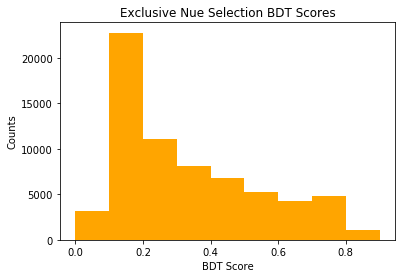

In [19]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [20]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

In [21]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)"

n_events here =  67348

6.7348
6
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
[0.0, 0.0, 0.0, 0.024009898610307445, 0.0, 0.04110990977924445]

SUMS
[0.004432086686190869, 0.010957549004236414, 0.16598438376367666, 0.9730459091888221, 16.504858200935395, 16.504858200935395, 55.89114800025766]
[0.006525462318045545, 0.15502683475944024, 0.8070615254251454, 15.531812291746572, 0.0, 39.38628979932226]

Wanted List:
[8.966174210331095, 18.462360921371022, 7.629225265191619, 2.5241172910701266, 1.0200419264673641, 0.48534303933904255, 0.16176268790551518, 0.06423227313003821, 0.04110990977924445, 0.0319222747371839]

True
Full numbers =  [ 315. 2141. 2054.  924.  485.  247.  135.   70.   53.   23.]
Sel

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[0.0, 0.0, 0.0, 0.02119951447293822, 0.0, 0.024215714798501153]

SUMS
[0.013341096240290732, 0.030548744017852566, 0.2050580017924693, 1.1096813368550642, 16.804863650619716, 16.804863650619716, 57.1039442563895]
[0.017207647777561834, 0.17450925777461673, 0.904623335062595, 15.69518231376465, 0.0, 40.29908060576978]

Wanted List:
[10.198383289803154, 17.607062916206477, 7.736167006019453, 2.6897821847808885, 1.086763893611973, 0.5049835034598261, 0.2494575039720246, 0.18311652216645768, 0.024215714798501153, 0.019148070951025886]

True
Full numbers =  [ 354. 2135. 1959. 1042.  507.  266.  153.   87.   61.   31.]
Selected numbers =  [ 354. 2135. 1959. 1041.  507.  266.  153.   87.   61.   30.]
In bin 0 , eff =  1.0  with error =  0.0
In bin 1 , eff =  1.0  with error =  0.0
In bin 2 , eff =  1.0  with error =  0.0
In bin 3 , eff =  0.9990403071017274  with error =  0.000959232282504121
In bin 4 , eff =  1.0  with error =  0.0
In bin 5 , eff =  1.0  with error =  0.0
In bin 6 , eff =  1

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprec

True
Full numbers =  [ 329. 2170. 2004.  995.  507.  278.  156.   73.   55.   25.]
Selected numbers =  [ 329. 2170. 2004.  995.  506.  278.  156.   73.   55.   23.]
In bin 0 , eff =  1.0  with error =  0.0
In bin 1 , eff =  1.0  with error =  0.0
In bin 2 , eff =  1.0  with error =  0.0
In bin 3 , eff =  1.0  with error =  0.0
In bin 4 , eff =  0.9980276134122288  with error =  0.001970440473249199
In bin 5 , eff =  1.0  with error =  0.0
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  1.0  with error =  0.0
In bin 8 , eff =  1.0  with error =  0.0
In bin 9 , eff =  0.92  with error =  0.05425863986500213

nue_ratio_nums:
[9.888325827167884, 18.58723320541303, 7.903864872254342, 2.822431873311636, 1.1645233740375835, 0.49827211601009935, 0.18591116886191372, 0.16720868509074194, 0.044878341883404005, 0.02053069263407691]


nue n_tot  [11.97362676 24.90897078 12.36642992  4.82309403  2.33002604  1.00127951
  0.48872127  0.27271108  0.11847412  0.02575269]

Returning
{'nue_nue

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Full numbers =  [ 336. 2169. 1974.  952.  513.  247.  136.   77.   58.   21.]
Selected numbers =  [ 336. 2168. 1974.  952.  513.  247.  136.   77.   58.   21.]
In bin 0 , eff =  1.0  with error =  0.0
In bin 1 , eff =  0.9995389580451821  with error =  0.00046093566272314523
In bin 2 , eff =  1.0  with error =  0.0
In bin 3 , eff =  1.0  with error =  0.0
In bin 4 , eff =  1.0  with error =  0.0
In bin 5 , eff =  1.0  with error =  0.0
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  1.0  with error =  0.0
In bin 8 , eff =  1.0  with error =  0.0
In bin 9 , eff =  1.0  with error =  0.0

nue_ratio_nums:
[10.005868244855883, 17.95410058784495, 7.345879936896439, 2.367749287466701, 1.137780302559072, 0.4929934057572183, 0.17642007548005267, 0.16376133636482137, 0.05629401297230885, 0.02418812060318487]


nue n_tot  [12.14901252 24.14809215 11.37772537  4.60410179  2.2529581   0.83979529
  0.44695955  0.2560485   0.08270744  0.03243029]

Returning
{'nue_nue': 0.00840908517562374

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Full numbers =  [ 290. 2143. 1973.  950.  469.  268.  162.   81.   40.   37.]
Selected numbers =  [ 290. 2143. 1973.  949.  469.  268.  162.   81.   40.   36.]
In bin 0 , eff =  1.0  with error =  0.0
In bin 1 , eff =  1.0  with error =  0.0
In bin 2 , eff =  1.0  with error =  0.0
In bin 3 , eff =  0.9989473684210526  with error =  0.001052077416456262
In bin 4 , eff =  1.0  with error =  0.0
In bin 5 , eff =  1.0  with error =  0.0
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  1.0  with error =  0.0
In bin 8 , eff =  1.0  with error =  0.0
In bin 9 , eff =  0.972972972972973  with error =  0.026659295238706564

nue_ratio_nums:
[9.448207754320023, 17.968641723878328, 7.6852307094414165, 2.446120215224448, 1.2064430607505017, 0.544238231007256, 0.2153691734118155, 0.15295428985302095, 0.08564668039382894, 0.008858936286086718]


nue n_tot  [11.33535638 23.95455802 11.824921    4.4765603   2.15427572  1.0697312
  0.43188536  0.34097435  0.15029641  0.050569  ]

Returning
{'

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


 , eff =  1.0  with error =  0.0
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  1.0  with error =  0.0
In bin 8 , eff =  1.0  with error =  0.0
In bin 9 , eff =  0.92  with error =  0.05425863986500213

nue_ratio_nums:
[7.227435907574533, 13.106169671792836, 5.265171347121065, 1.841578682767828, 0.7792412047085301, 0.33972909137422036, 0.1889109033402363, 0.08905307739718538, 0.07742811315324616, 0.03946815119581383]


nue n_tot  [ 8.63473953 17.87277236  8.2117637   3.53059994  1.55195096  0.68461233
  0.38668028  0.20083534  0.13682034  0.05221349]

Returning


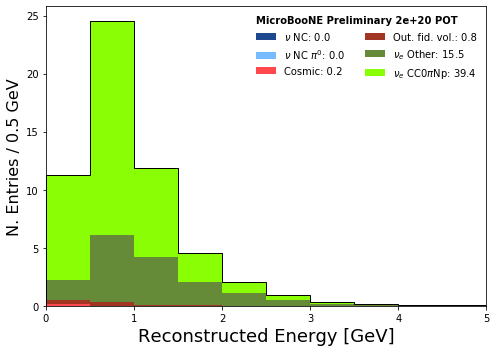

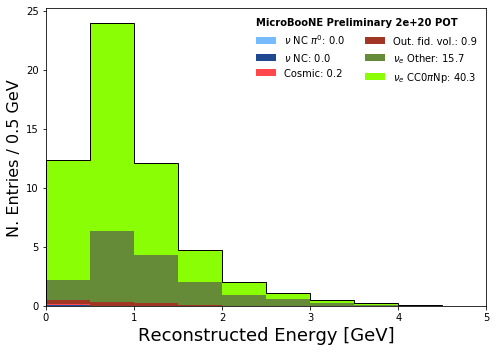

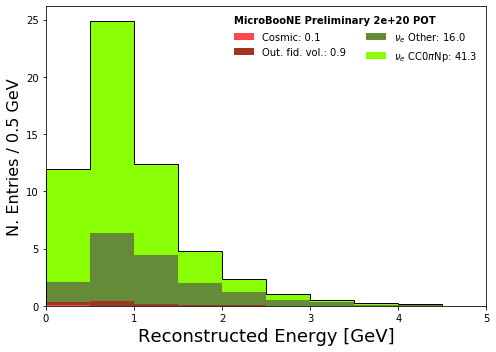

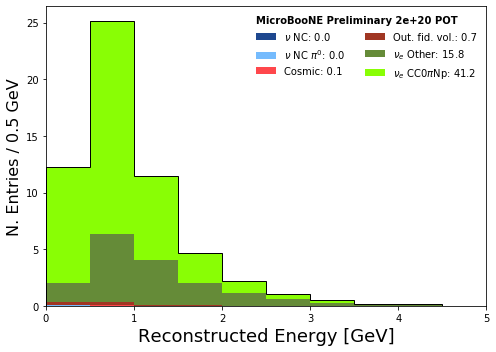

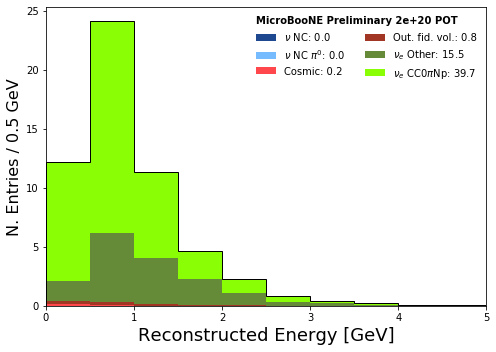

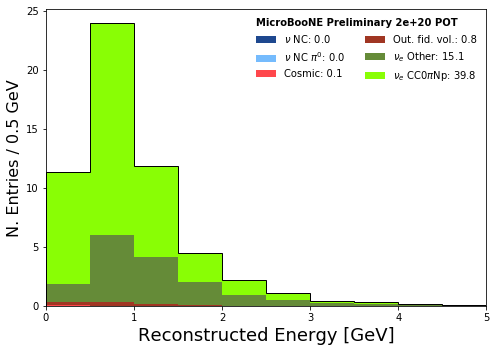

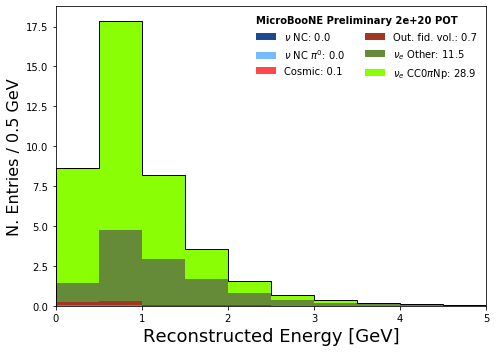

In [24]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    nueratio  = pot/2.37838e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)
    

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


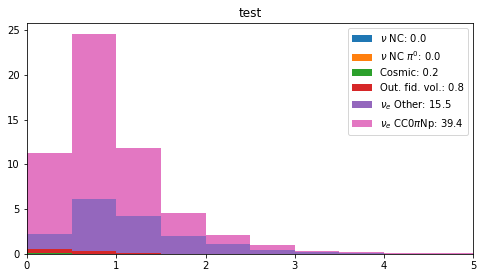

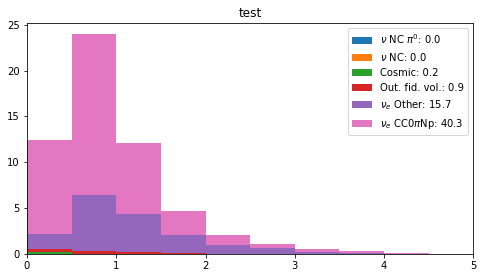

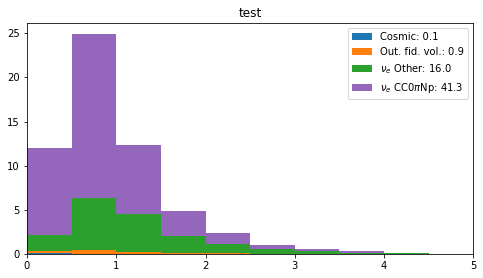

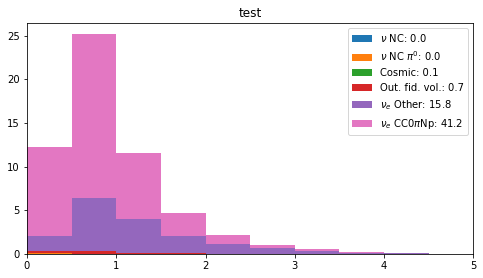

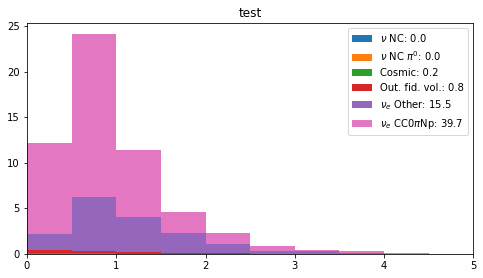

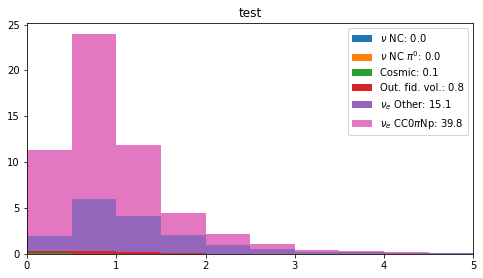

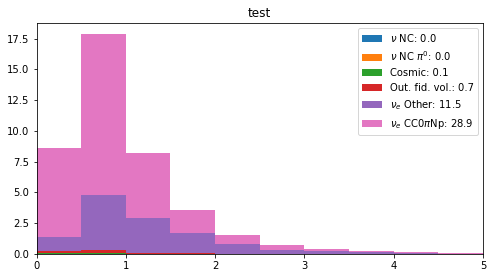

In [25]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

In [26]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

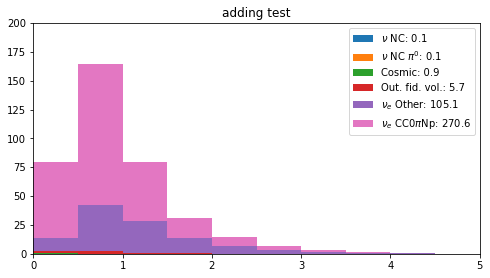

In [27]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$",
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 200])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [28]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 1

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[0.0, 0.0, 0.0, 0.33261140818791546, 0.0, 0.401709130044992]

SUMS
[0.05927902685497141, 0.14546793714651995, 1.0094312044518976, 6.663576724895168, 111.75253259131607, 111.75253259131607, 382.34256532938025]
[0.08618891029154854, 0.8639632673053776, 5.6541455204432705, 105.0889558664209, 0.0, 270.59003273806417]

Wanted List:
[0.5995328993650686, 0.18374593687008967, 0.04697199970242438, 0.005733099314890966, 0.008448527597861966, 0.008366583177936038, 0.011164221277106146, 0.0, 0.0, 0.0]

[0.5995328993650686, 0.18374593687008967, 0.04697199970242438, 0.005733099314890966, 0.008448527597861966, 0.008366583177936038, 0.011164221277106146, 0.0, 0.0, 0.0]


In [29]:
#varss_tot[0].to_csv('nue_nue_varstot.csv')
#weights_tot[0].to_csv('nue_nue_varstot.csv')

#print(varss_tot[0])


vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

vars_tot_df.to_csv('nue_nue_varstot.csv')
weights_tot_df.to_csv('nue_nue_weightstot.csv')